# Метод Ньютона и Квази-Ньютоновские методы

Line-search методы, где направление выбирается с помощью аппроксимации гессиана:

$$
p_k = -B_k^{-1} \nabla f
$$

In [23]:
from core.gradient_descent import wolfe_conditions_search, point_number_terminate_condition, fixed_step_search
%load_ext autoreload
%autoreload 2

from core.high_order_optimization import *
from core.optimizer_evaluator import *
from core.utils import *
from core.visualizer import *
import numpy as np
from tabulate import tabulate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def evaluate_quasi_newton_methods_on_2dim(methods):
    print("—————— 2 Dimensions ——————")

    q = QuadraticForm(np.array([
        [10, 2],
        [2, 2]
    ]))
    roi = SearchRegion2d((-2, 2), (-2, 2))
    visualize_function_3d(q, roi)

    qg = q.gradient_function()

    for (name, get_approximator, get_initial_approximator) in methods:
        visualize_optimizing_process(q, roi, np.array(newton_optimize(
            q, qg, get_approximator(q, qg), np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10), get_initial_approximator(q, qg)
        )), 0).suptitle(name)

def evaluate_quasi_newton_methods_on_rosen(methods):
    print("—————— Many Dimensions Rosenbrock ——————")
    from scipy.optimize import rosen, rosen_der

    dims = [2, 10, 50, 100]
    data = { 'dimensions': dims }
    for (name, get_approximator, get_initial_approximator) in methods:
        results = data[name] = []
        for n in dims:
            f = rosen
            rg = rosen_der
            try:
                points = newton_optimize(f, rg, get_approximator(f, rg),
                                              # random_normalized_vector(n),  # Or just zero?
                                              np.zeros((n,)),
                                              wolfe_conditions_search(0.1, 0.9),
                                              # fibonacci_search(30),
                                              # fixed_step_search(1),
                                              precision_termination_condition,
                                              get_initial_approximator(f, rg)
                                              )
                results.append(str(len(points)))
                print(f"Iterations until convergence for n={n}: {len(points)}")
            except Exception as e:
                results.append("×")
                print(f"At n={n}: Failed with {e}")

    print(tabulate(data, headers="keys", tablefmt="grid"))

def evaluate_quasi_newton_methods_on_exp_parabola(methods):
    print("—————— Many Dimensions && complicated ——————")

    dims = [2, 10, 50, 100]
    data = { 'dimensions': dims }

    for (name, get_approximator, get_initial_approximator) in methods:
        results = data[name] = []
        for n in dims:
            form = generate_positive_definite_quadratic_form(n, 10, random_orthonormal_basis)
            multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))
            mg = symmetric_gradient_computer(multipiled)
            points = newton_optimize(multipiled, mg, get_approximator(multipiled, mg), random_normalized_vector(form.n),
                                      wolfe_conditions_search(0.1, 0.9),
                                      # fibonacci_search(30),
                                      # fixed_step_search(1),
                                      precision_termination_condition,
                                      get_initial_approximator(multipiled, mg)
                                      )
            print(f"Iterations until convergence for n={n}: {len(points)}")
            results.append(str(len(points)))


    print(tabulate(data, headers="keys", tablefmt="grid"))


def evaluate_quasi_newton_methods_on_form(methods, tl_sec):
    print("—————— Many Dimensions ——————")
    dims = [2, 10, 50, 100, 1000]
    data = { 'dimensions': dims }
    for (name, get_approximator, get_initial_approximator) in methods:
        results = data[name] = []
        for n in dims:
            form = generate_positive_definite_quadratic_form(n, 1000, random_orthonormal_basis)

            try:
                with time_limit(tl_sec, 'sleep'):
                    fg = form.gradient_function()
                    points = newton_optimize(form, fg, get_approximator(form, fg), random_normalized_vector(form.n),
                                                  wolfe_conditions_search(0.1, 0.9),
                                                  # fibonacci_search(30),
                                                  precision_termination_condition, get_initial_approximator(form, fg))
                    print(f"Iterations until convergence for n={n}: {len(points)}")
                    results.append(str(len(points)))
            except Exception:
                results.append("TL")
                print("TL")

    print(tabulate(data, headers="keys", tablefmt="grid"))



In [9]:
quasi_newton_methods = [
    ("Steepest descent", lambda f, g: GivenNewtonDirectionApproximator(lambda x: None), lambda f, g: none_approximation), # For comparison
    ("Newton", lambda f, g: GivenNewtonDirectionApproximator(lambda x: np.linalg.inv(f.hessian_function()(x))) if  isinstance(f, QuadraticForm) else GivenNewtonDirectionApproximator.numerically_computing(f, g), lambda f, g: none_approximation),
    ("BFGS", lambda f, g: BFGSNewtonDirectionApproximator(), lambda f, g: none_approximation),
    ("L-BFGS[m=3]", lambda f, g: LBFGSNewtonDirectionApproximator(3), lambda f, g: none_approximation),
    ("L-BFGS[m=10]", lambda f, g: LBFGSNewtonDirectionApproximator(10), lambda f, g: none_approximation)
]

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [-0.0078125 -0.0703125] with f(x*) = 0.0126953125
[newton_optimize] Computed initial approximation
Best value found: x* = [-1.30923418e-09  8.72822784e-10] with f(x*) = 1.4093662825922414e-17
[newton_optimize] Computed initial approximation
Best value found: x* = [ 3.96536283e-08 -2.98768726e-08] with f(x*) = 1.2770451775111171e-14
[newton_optimize] Computed initial approximation
Best value found: x* = [ 3.90219439e-08 -2.99232287e-08] with f(x*) = 1.2347270099277023e-14
[newton_optimize] Computed initial approximation
Best value found: x* = [ 3.90219439e-08 -2.99232286e-08] with f(x*) = 1.2347270099276946e-14


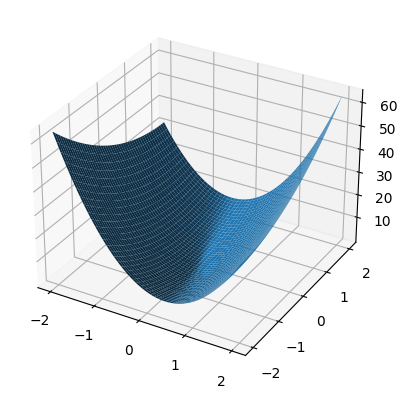

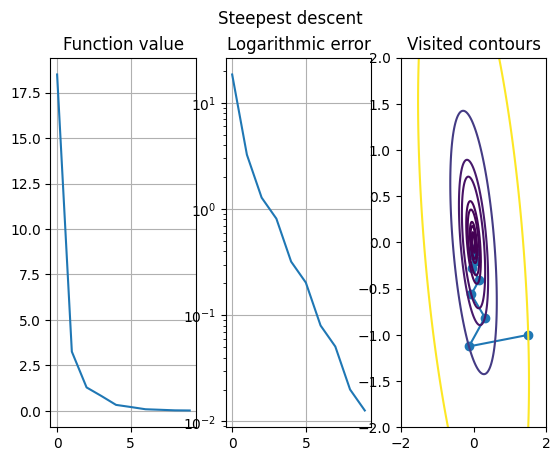

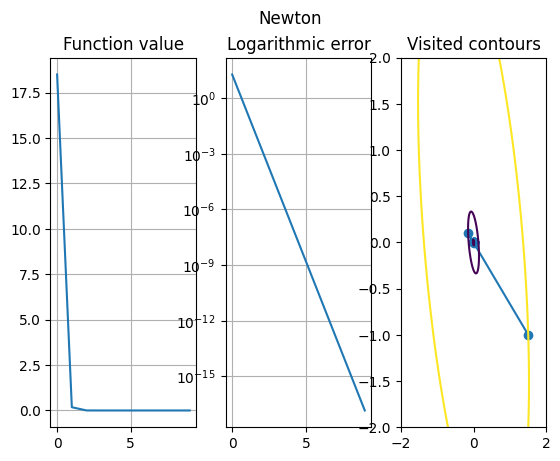

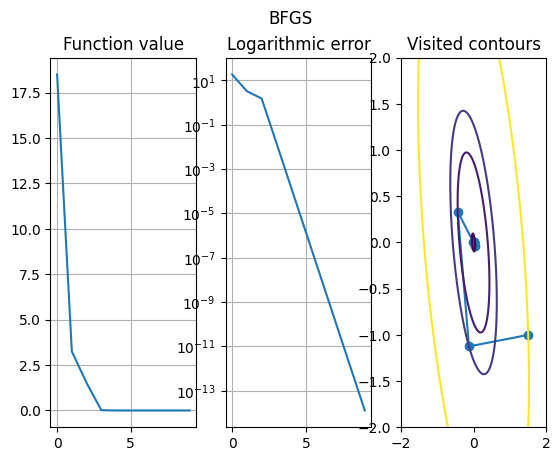

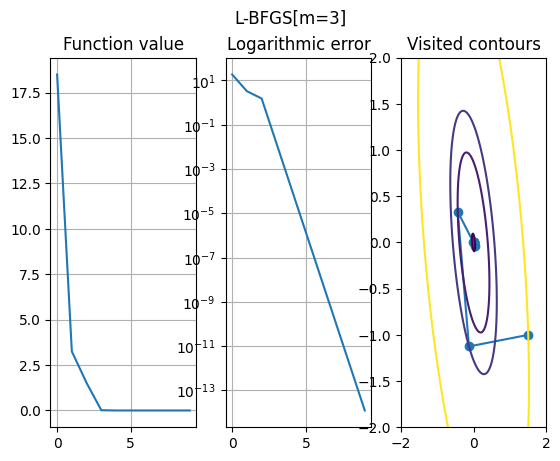

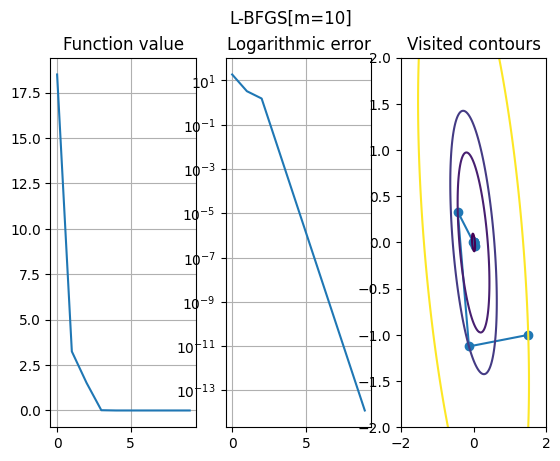

In [10]:
evaluate_quasi_newton_methods_on_2dim(quasi_newton_methods)

# RosenBrock

In [18]:
evaluate_quasi_newton_methods_on_rosen(quasi_newton_methods)

—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 4164
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 6782
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 12656
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 19758
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 13
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 24
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 84
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 158
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 16
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 56
[newton_optimize] Computed initial appr

# Заряженная форма (большая размерность, большое число обусловленности)

In [33]:
evaluate_quasi_newton_methods_on_form(quasi_newton_methods, 10)

—————— Many Dimensions ——————
Iterations until convergence for n=2: 954
Iterations until convergence for n=10: 2688
Iterations until convergence for n=50: 2615
Iterations until convergence for n=100: 2640
TL
Iterations until convergence for n=2: 8
Iterations until convergence for n=10: 8
Iterations until convergence for n=50: 8
Iterations until convergence for n=100: 8
TL
Iterations until convergence for n=2: 9
Iterations until convergence for n=10: 17
Iterations until convergence for n=50: 59
Iterations until convergence for n=100: 109
TL
Iterations until convergence for n=2: 9
Iterations until convergence for n=10: 36
Iterations until convergence for n=50: 53
Iterations until convergence for n=100: 90
Iterations until convergence for n=1000: 168
Iterations until convergence for n=2: 8
Iterations until convergence for n=10: 28
Iterations until convergence for n=50: 66
Iterations until convergence for n=100: 86
Iterations until convergence for n=1000: 105
+--------------+--------------

In [42]:
evaluate_quasi_newton_methods_on_exp_parabola(quasi_newton_methods)

—————— Many Dimensions && complicated ——————
Iterations until convergence for n=2: 39
Iterations until convergence for n=10: 37


C:\Users\Vova\AppData\Local\Temp\ipykernel_26828\403433354.py:57: RuntimeWarning: overflow encountered in exp
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


Iterations until convergence for n=50: 37
Iterations until convergence for n=100: 35
Iterations until convergence for n=2: 7
Iterations until convergence for n=10: 8
Iterations until convergence for n=50: 8
Iterations until convergence for n=100: 8
Iterations until convergence for n=2: 10
Iterations until convergence for n=10: 18


C:\Users\Vova\AppData\Local\Temp\ipykernel_26828\403433354.py:57: RuntimeWarning: overflow encountered in double_scalars
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


Iterations until convergence for n=50: 62
Iterations until convergence for n=100: 100
Iterations until convergence for n=2: 10
Iterations until convergence for n=10: 22
Iterations until convergence for n=50: 21
Iterations until convergence for n=100: 34
Iterations until convergence for n=2: 10
Iterations until convergence for n=10: 34
Iterations until convergence for n=50: 41
Iterations until convergence for n=100: 46
+--------------+--------------------+----------+--------+---------------+----------------+
|   dimensions |   Steepest descent |   Newton |   BFGS |   L-BFGS[m=3] |   L-BFGS[m=10] |
+==============+====================+==========+========+===============+================+
|            2 |                 39 |        7 |     10 |            10 |             10 |
+--------------+--------------------+----------+--------+---------------+----------------+
|           10 |                 37 |        8 |     18 |            22 |             34 |
+--------------+----------------